In [12]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Загрузка данных

In [13]:
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

# Реализация KNN

In [14]:
class KNN:
    def __init__(self, k: int = 3):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.unique_labels_count = None

    def fit(self, X: np.ndarray, y: np.array):
        self.X_train = X
        self.y_train = y
        self.unique_labels_count = len(np.unique(self.y_train))
        return self

    def predict_proba(self, X: np.ndarray):
        probs = np.zeros((len(X), self.unique_labels_count))

        for i, x in enumerate(X):
            distances = np.array([self.euclidean_distance(x, xt) for xt in self.X_train])
            sorted_indices = np.argsort(distances)
            distances /= distances[sorted_indices[self.k]]
            kernels = self.gaussian_kernel(distances[sorted_indices])
            for w, y in zip(kernels, self.y_train[sorted_indices]):
                probs[i][y] += w
            probs[i] /= probs[i].sum()

        return probs

    def predict(self, X: np.ndarray):
        return np.argmax(self.predict_proba(X), axis=1)

    @staticmethod
    def euclidean_distance(x1: np.array, x2: np.array):
        return np.linalg.norm(x1 - x2)

    @staticmethod
    def gaussian_kernel(r: np.array):
        return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * r ** 2)

In [15]:
knn = KNN(3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy', np.mean(y_pred == y_test))

Accuracy 0.6666666666666666


# Leave-One-Out

In [16]:
def leave_one_out(
    X: np.ndarray,
    y: np.array,
):
    for i in range(len(X)):
        yield X[i], y[i], np.delete(X, i, 0), np.delete(y, i)

# Подбор параметра K

In [17]:
def print_best_k(errors: list[tuple[int, float]]):
    sorted_errors = sorted(errors, key=lambda e: (e[1], e[0]))
    for k, error_rate in sorted_errors[:10]:
        print(f'{k=}, {error_rate=:.2f}')

## Leave-One-Out

In [18]:
loo_errors = []

for k in range(1, len(X_train) - 1):
    loo_errors.append([k, 0])
    for xi, yi, X_rest, y_rest in leave_one_out(X_train, y_train):
        yi_pred, = KNN(k).fit(X_rest, y_rest).predict([xi])
        loo_errors[-1][1] += (yi != yi_pred)
    loo_errors[-1][1] /= len(X_train)

print('Лучшие параметры K по Leave-One-Out')
print_best_k(loo_errors)

Лучшие параметры K по Leave-One-Out
k=1, error_rate=0.24
k=3, error_rate=0.25
k=2, error_rate=0.26
k=4, error_rate=0.26
k=5, error_rate=0.27
k=8, error_rate=0.28
k=13, error_rate=0.28
k=21, error_rate=0.28
k=9, error_rate=0.29
k=10, error_rate=0.29


## Hold-Out

In [19]:
empiric_errors = []

for k in range(1, len(X_train)):
    y_pred = KNN(k).fit(X_train, y_train).predict(X_test)
    error_rate = np.mean(y_test != y_pred)
    empiric_errors.append((k, error_rate))

print('Лучшие параметры K полученные из экспериментам')
print_best_k(empiric_errors)

Лучшие параметры K полученные из экспериментам
k=11, error_rate=0.22
k=12, error_rate=0.22
k=13, error_rate=0.22
k=14, error_rate=0.22
k=15, error_rate=0.22
k=16, error_rate=0.22
k=17, error_rate=0.22
k=18, error_rate=0.22
k=19, error_rate=0.22
k=20, error_rate=0.22


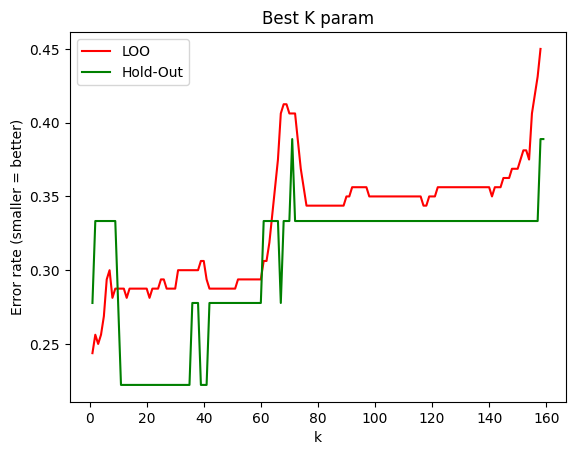

In [20]:
import matplotlib.pyplot as plt

plt.title('Best K param')
plt.plot(*zip(*loo_errors), color='r', label='LOO')
plt.plot(*zip(*empiric_errors), color='g', label='Hold-Out')
plt.xlabel('k')
plt.ylabel('Error rate (smaller = better)')
plt.legend()
plt.show()

# Сравнение с эталонной реализацией

In [21]:
import time

from sklearn.neighbors import KNeighborsClassifier

ks = (1, 10, 20)
impls = (KNN, KNeighborsClassifier)

for impl in impls:
    for k in ks:
        start = time.monotonic()
        neigh = impl(k)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        speed = time.monotonic() - start
        print(f'{impl.__name__}(k={k})\n'
              f'Time: {speed}s\n'
              f'Accuracy: {np.mean(y_pred == y_test)}\n')


KNN(k=1)
Time: 0.0065152079332619905s
Accuracy: 0.7222222222222222

KNN(k=10)
Time: 0.0052839580457657576s
Accuracy: 0.7222222222222222

KNN(k=20)
Time: 0.005104833049699664s
Accuracy: 0.7777777777777778

KNeighborsClassifier(k=1)
Time: 0.0022031250409781933s
Accuracy: 0.7777777777777778

KNeighborsClassifier(k=10)
Time: 0.0009392499923706055s
Accuracy: 0.5555555555555556

KNeighborsClassifier(k=20)
Time: 0.0008967090398073196s
Accuracy: 0.7777777777777778
